In [1]:
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
#!git clone https://github.com/jmorala/TFMDS.git

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [2]:
import os
import sys

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    project_dir = '/content/TFMDS'  # Ruta típica en Colab
    os.chdir(project_dir)
else:
    # En VS Code local
    project_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(project_dir)

# Agregar el directorio del proyecto al path de Python
# (solo si no está ya en el path)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

# Verificación
print("Directorio de trabajo:", os.getcwd())
print("Python path incluye proyecto:", project_dir in sys.path)

Directorio de trabajo: C:\Users\jmora\Documents\TFMDS
Python path incluye proyecto: True


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import scipy.stats as st
import warnings
import time
warnings.filterwarnings('ignore')

# Importar funciones personalizadas
from lib.metricas import calcular_metricas, comparar_metricas, resumen_metricas, agregar_estadisticas_error
from lib.graficos import (grafico_real_vs_prediccion, grafico_scatter_prediccion, grafico_comparacion_metricas,
                          grafico_distribucion_error, grafico_feature_importance, dashboard_prediccion)

## Lectura de fichero y adaptación de los tipos


In [4]:
df_train = pd.read_csv('datos/df_train.csv', sep=';', parse_dates=['idSecuencia'])
df_test = pd.read_csv('datos/df_test.csv', sep=';', parse_dates=['idSecuencia'])

print("\nInformación de las columnas y tipos de datos:")
print(df_train.info())
print(df_test.info())


Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625800 entries, 0 to 625799
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idSecuencia         625800 non-null  datetime64[ns]
 1   producto            625800 non-null  int64         
 2   udsVenta            625800 non-null  int64         
 3   bolPromocion        625800 non-null  int64         
 4   bolOpen             625800 non-null  int64         
 5   bolHoliday          625800 non-null  int64         
 6   udsStock            625800 non-null  int64         
 7   rotura_stock        625800 non-null  bool          
 8   dia_semana          625800 non-null  int64         
 9   mes                 625800 non-null  int64         
 10  trimestre           625800 non-null  int64         
 11  lag_ventas_1        625800 non-null  float64       
 12  lag_ventas_2        625800 non-null  fl

# Random Forests (RF)

- Determinar características utilizar FEATURES
- Descomponer serie en Train y Test
- Características a Normalizar/Estandarizar o codificar
- Crear modelos estimando hiperparámetros
- Valorar modelos




In [5]:
# Eliminar días que la tienda está cerrada bolOpne == 0 ya que en modelos tipo Random Forest no aportan nada
df_train = df_train[df_train['bolOpen'] == 1].copy()
df_test = df_test[df_test['bolOpen'] == 1].copy()

# Preparación de datos

In [6]:
# ============================================================================
# CONFIGURACIÓN INICIAL
# ============================================================================

FEATURES = [
    'producto_encoded', 'bolPromocion', 'bolHoliday', 'Cluster',
    'dia_semana', 'mes', 'trimestre',
    'lag_ventas_1', 'lag_ventas_2', 'lag_ventas_3', 'lag_ventas_4',
    'lag_ventas_5', 'lag_ventas_6', 'lag_ventas_7',
    'media_mes_anterior', 'EWMA_corto', 'EWMA_largo', 'Tendencia_EWMA'
]

TARGET = 'udsVenta'

# ============================================================================
# 📊 LISTA PARA ALMACENAR TODAS LAS MÉTRICAS
# ============================================================================
todas_metricas = []  # ← Lista global para todas las métricas

print("="*100)
print("🚀 INICIANDO ANÁLISIS COMPLETO DE RANDOM FOREST")
print("="*100)


🚀 INICIANDO ANÁLISIS COMPLETO DE RANDOM FOREST


# Random Forest global

In [7]:

# ============================================================================
# 1. MODELO GLOBAL CON GRID SEARCH
# ============================================================================

print("\n" + "="*100)
print("📍 MODELO 1: RANDOM FOREST GLOBAL")
print("="*100)

# Preparar datos
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

print(f"\n✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")

# Grid Search
print("\n🔍 Búsqueda de hiperparámetros con GridSearchCV...")

tscv = TimeSeriesSplit(n_splits=2)

param_dist_rf = {
    'n_estimators': st.randint(200, 600),
    'max_depth': st.randint(4, 18),
    'min_samples_split': st.randint(2, 15),
    'min_samples_leaf': st.randint(1, 8),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=30,                               # velocidad vs calidad
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

start_time = time.perf_counter()
grid_search.fit(X_train, y_train)
elapsed = time.perf_counter() - start_time

print(f"✅ GridSearchCV completado en {elapsed:.2f} segundos")
print(f"\n🏆 Mejores hiperparámetros:")
for k,v in grid_search.best_params_.items():
    print(f"   {k}: {v}")

best_rf = grid_search.best_estimator_

# Predicciones
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calcular métricas y GUARDAR
metricas_train_global = calcular_metricas(y_train, y_train_pred, 'RF Global Train')
metricas_test_global = calcular_metricas(y_test, y_test_pred, 'RF Global Test')

# todas_metricas.append(metricas_train_global)
todas_metricas.append(metricas_test_global)

print("\n📊 Métricas del Modelo Global:")
resumen_metricas([metricas_train_global, metricas_test_global])



📍 MODELO 1: RANDOM FOREST GLOBAL

✅ X_train shape: (521202, 18)
✅ X_test shape: (23244, 18)

🔍 Búsqueda de hiperparámetros con GridSearchCV...
Fitting 2 folds for each of 30 candidates, totalling 60 fits
✅ GridSearchCV completado en 1549.51 segundos

🏆 Mejores hiperparámetros:
   bootstrap: True
   max_depth: 13
   max_features: sqrt
   min_samples_leaf: 4
   min_samples_split: 14
   n_estimators: 378


KeyboardInterrupt: 

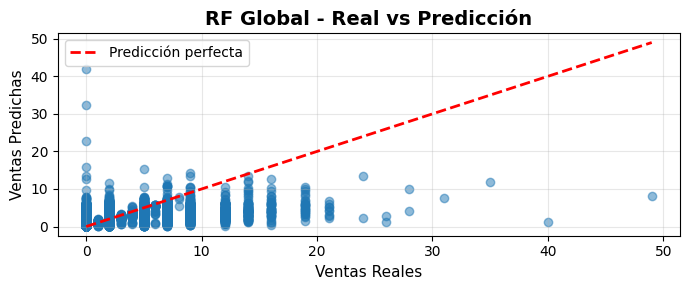

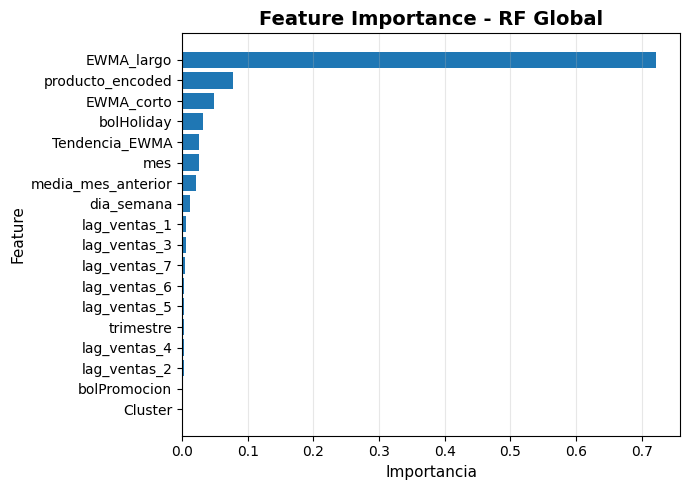

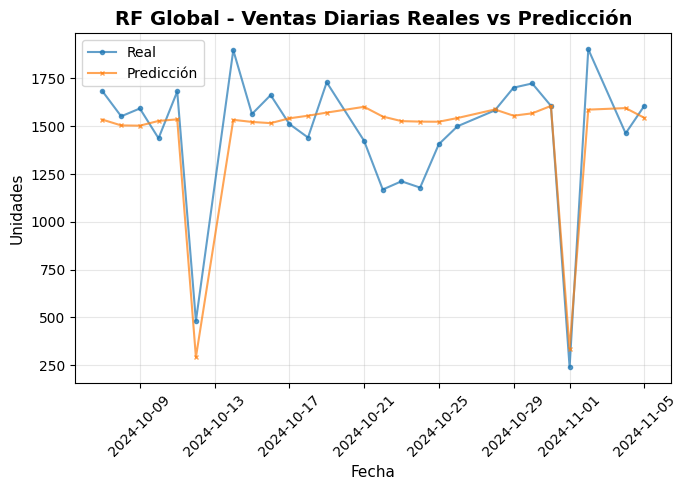

In [8]:

# Visualizaciones del modelo global
df_test_viz = df_test.copy()
df_test_viz['prediccion'] = y_test_pred
df_test_viz['error'] = y_test_pred - df_test_viz[TARGET]

grafico_scatter_prediccion(
    df=df_test_viz,
    col_real=TARGET,
    col_pred='prediccion',
    titulo='RF Global - Real vs Predicción',
    figsize=(7, 3)
)

grafico_feature_importance(
    modelo=best_rf,
    feature_names=FEATURES,
    top_n=len(FEATURES),
    titulo='Feature Importance - RF Global',
    figsize=(7, 5)
)

# Crear dataframe que contenga la suma por día de las predicciones y valores reales
df_daily = df_test_viz.copy()
df_daily['fecha'] = df_daily['idSecuencia'].dt.date
df_daily_sum = df_daily.groupby('fecha')[[TARGET, 'prediccion']].sum().reset_index()
grafico_real_vs_prediccion(
    df=df_daily_sum,
    col_real=TARGET,
    col_pred='prediccion',
    col_fecha='fecha',
    titulo='RF Global - Ventas Diarias Reales vs Predicción',
    figsize=(7, 5)
)


# Random Forest por Cluster


📍 MODELO 2: RANDOM FOREST POR CLUSTER

🔄 Entrenando modelo para Cluster 0...
   ✓ MAE: 1.81 | RMSE: 2.59 | R²: 0.0896


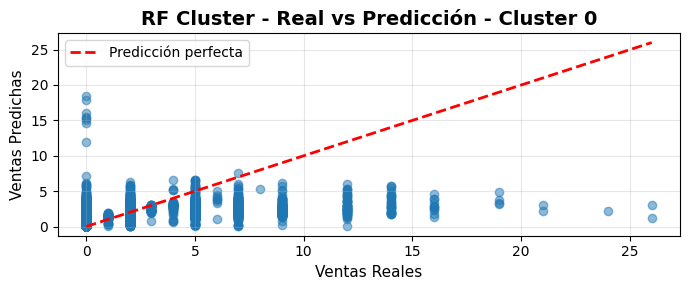

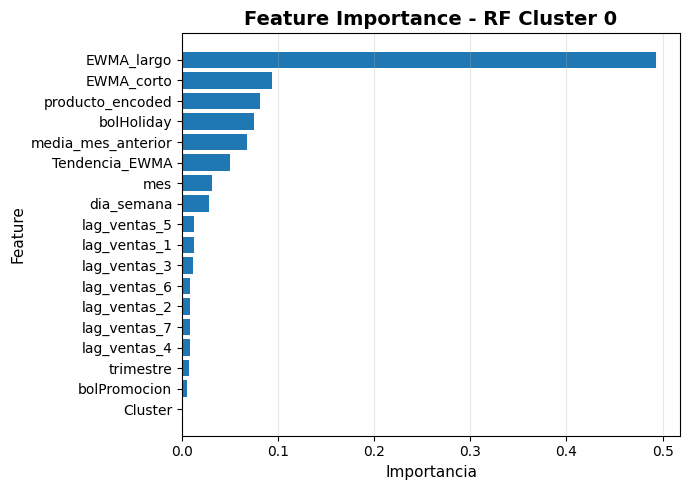

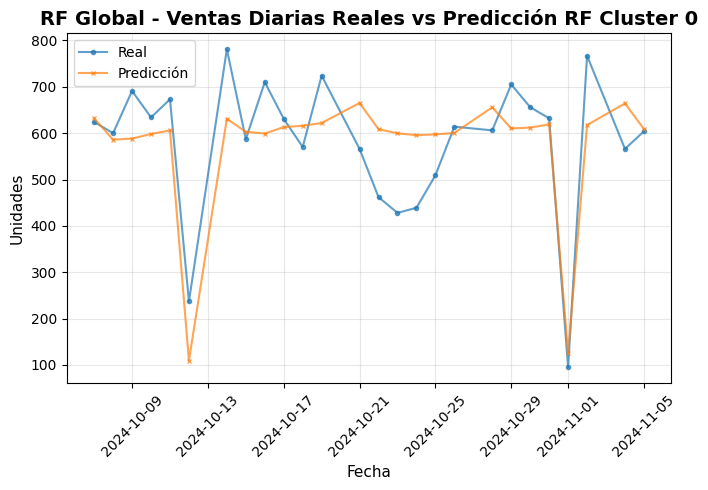


   📍 Producto representativo: 17 (26 registros)
   📊 Estadísticas del error:
      Error medio:             -0.02
      Error abs medio:          1.81
      Error máximo:            24.79


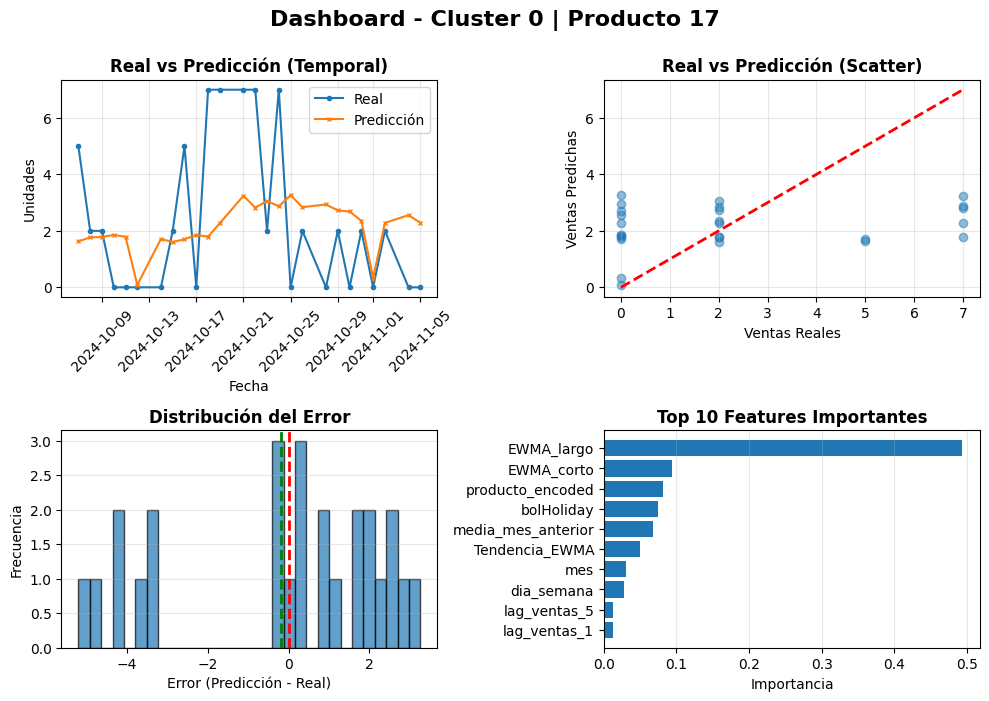


🔄 Entrenando modelo para Cluster 1...
   ✓ MAE: 2.78 | RMSE: 3.60 | R²: 0.1400


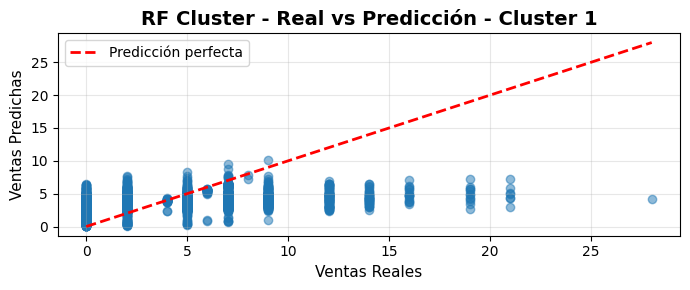

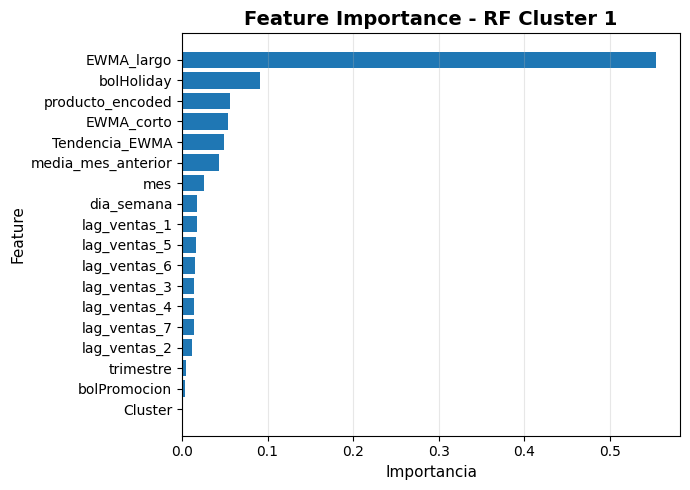

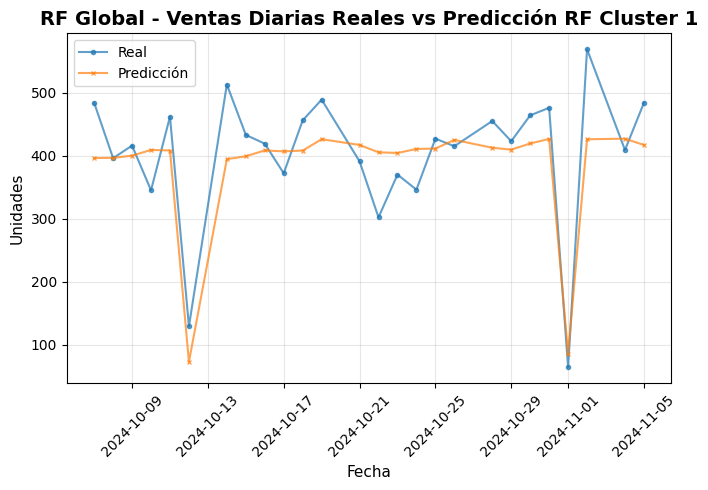


   📍 Producto representativo: 4 (26 registros)
   📊 Estadísticas del error:
      Error medio:             -0.18
      Error abs medio:          2.78
      Error máximo:            23.83


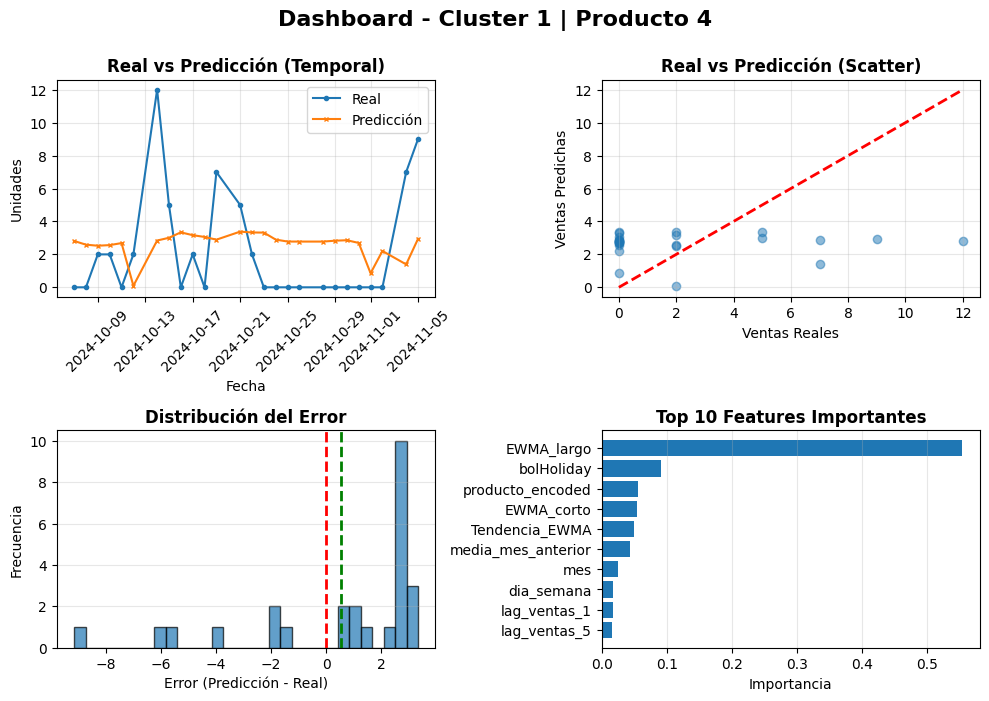


🔄 Entrenando modelo para Cluster 2...
   ✓ MAE: 3.63 | RMSE: 5.12 | R²: 0.1895


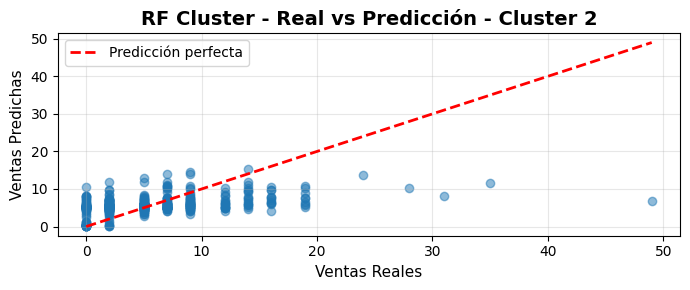

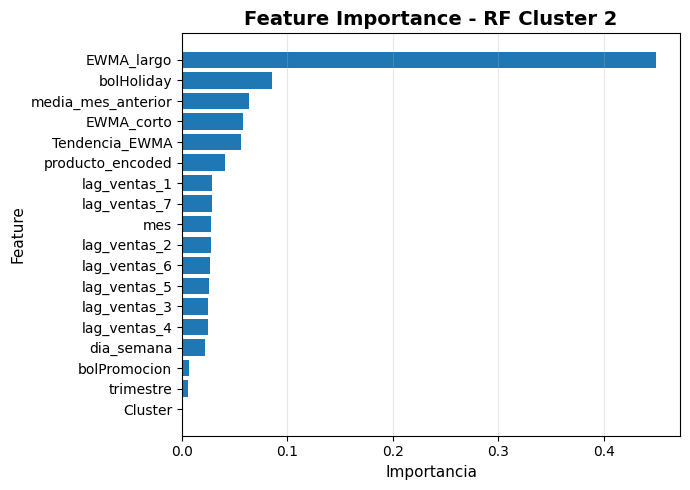

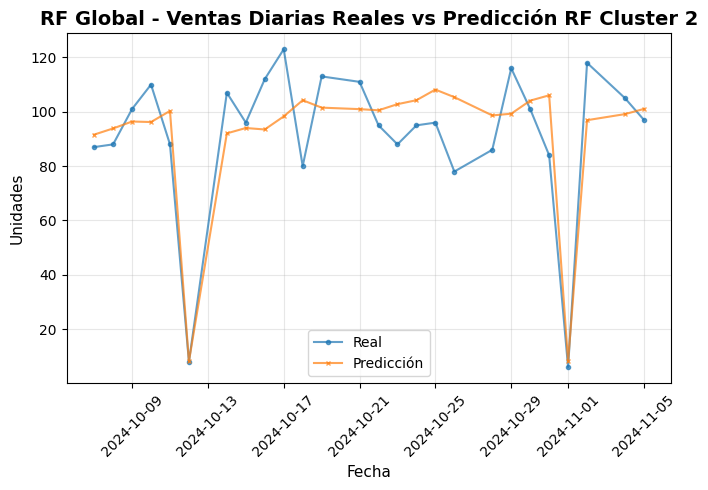


   📍 Producto representativo: 1 (26 registros)
   📊 Estadísticas del error:
      Error medio:              0.04
      Error abs medio:          3.63
      Error máximo:            42.33


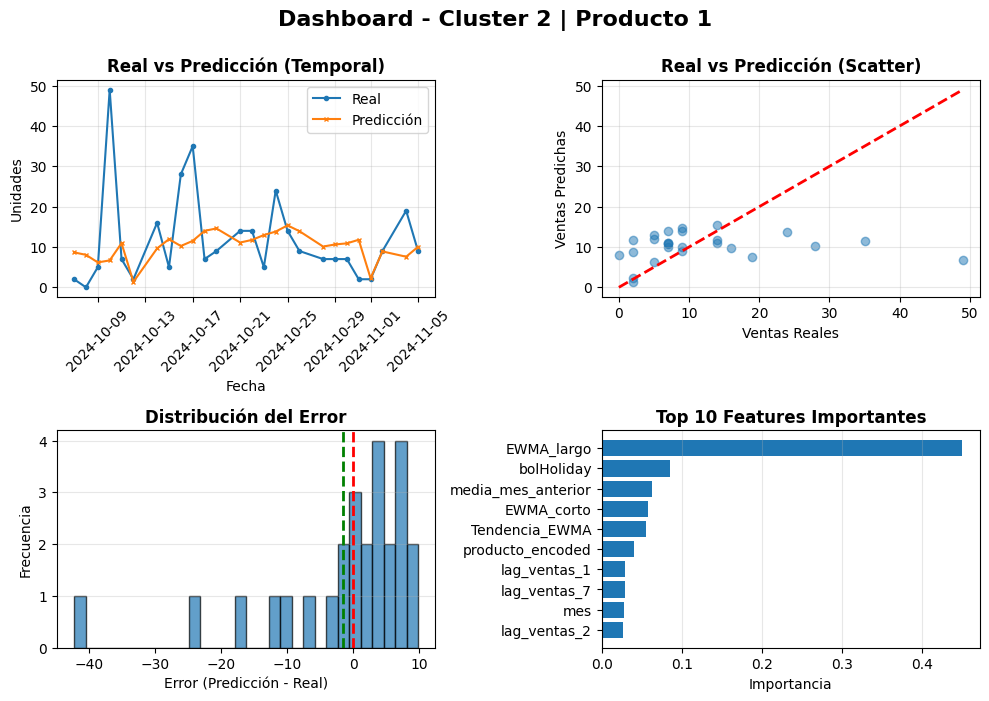


🔄 Entrenando modelo para Cluster 3...
   ✓ MAE: 1.09 | RMSE: 1.67 | R²: 0.0639


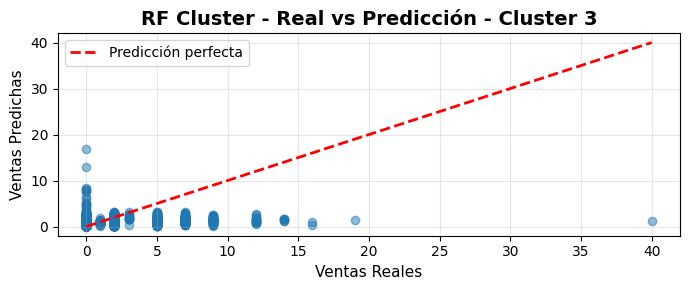

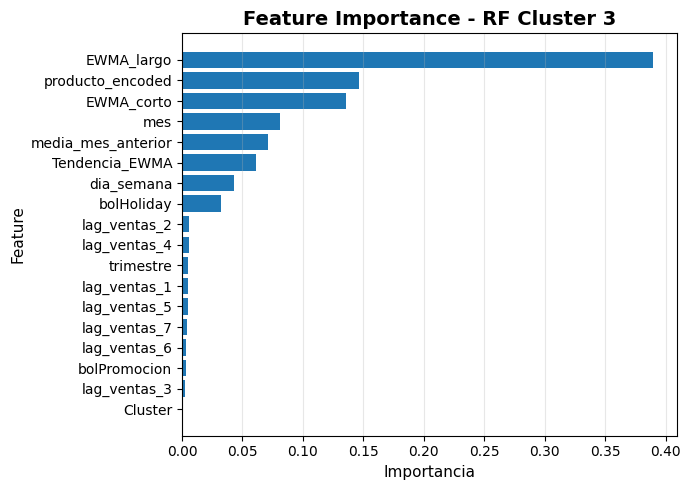

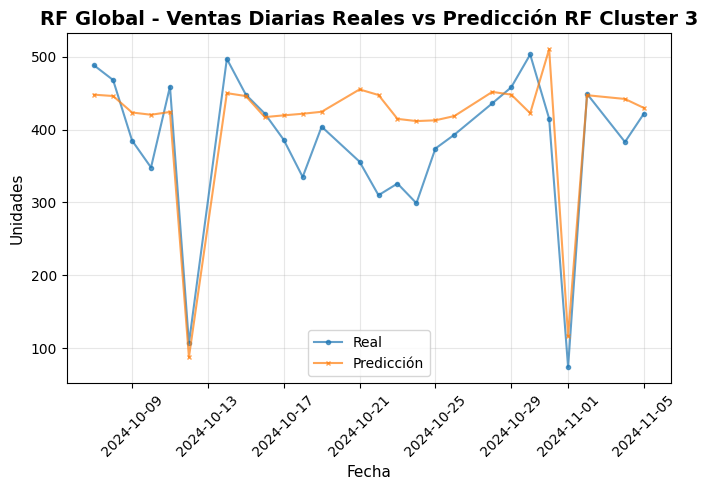


   📍 Producto representativo: 38 (26 registros)
   📊 Estadísticas del error:
      Error medio:              0.06
      Error abs medio:          1.09
      Error máximo:            38.78


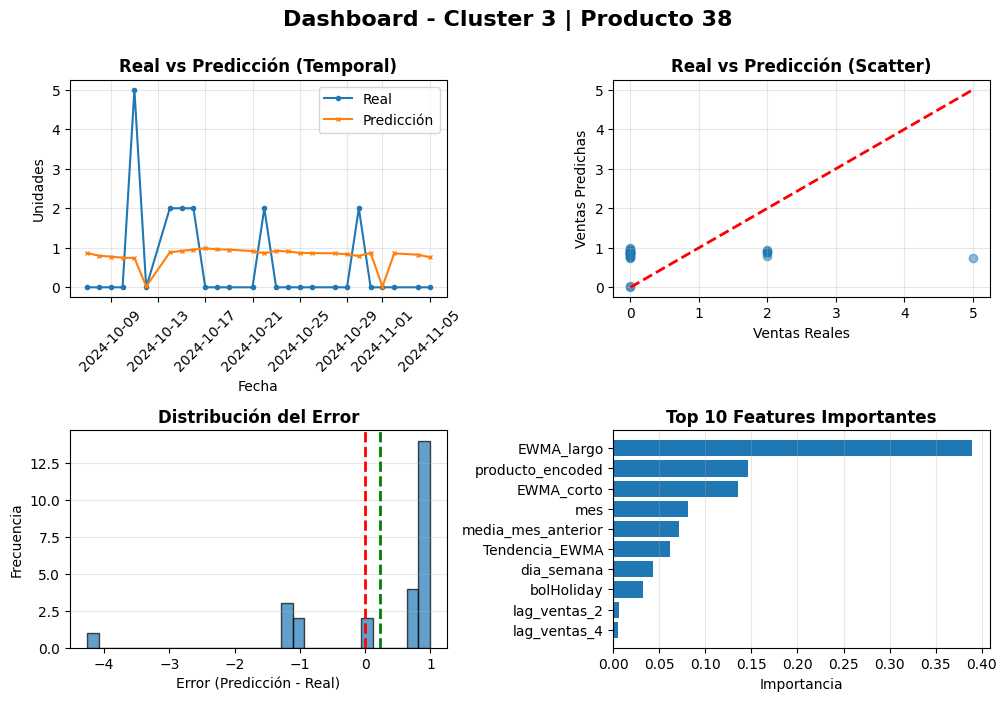

In [9]:

# ============================================================================
# 2. MODELOS POR CLUSTER
# ============================================================================

print("\n" + "="*100)
print("📍 MODELO 2: RANDOM FOREST POR CLUSTER")
print("="*100)

modelos_cluster = {}

for cluster in sorted(df_train['Cluster'].unique()):
    print(f"\n🔄 Entrenando modelo para Cluster {cluster}...")
    
    # Filtrar datos
    train_cluster = df_train[df_train['Cluster'] == cluster]
    test_cluster = df_test[df_test['Cluster'] == cluster].dropna()
    
    if len(test_cluster) == 0:
        print(f"   ⚠️  No hay datos de validación")
        continue
    
    X_train_c = train_cluster[FEATURES]
    y_train_c = train_cluster[TARGET]
    X_test_c = test_cluster[FEATURES]
    y_test_c = test_cluster[TARGET]
    
    # Entrenar
    rf_cluster = RandomForestRegressor(
        n_estimators=140,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    
    rf_cluster.fit(X_train_c, y_train_c)
    y_pred_c = rf_cluster.predict(X_test_c)
    
    # modelos_cluster[cluster] = rf_cluster
    
    # Calcular métricas y GUARDAR
    metricas_cluster = calcular_metricas(y_test_c, y_pred_c, f"RF Cluster {cluster}")
    todas_metricas.append(metricas_cluster)
    
    print(f"   ✓ MAE: {metricas_cluster['MAE']:.2f} | RMSE: {metricas_cluster['RMSE']:.2f} | R²: {metricas_cluster['R2']:.4f}")
    
    # Visualizaciones del modelo cluster
    df_test_viz = test_cluster.copy()
    df_test_viz['prediccion'] = y_pred_c
    df_test_viz['error'] = y_pred_c - df_test_viz[TARGET]

    grafico_scatter_prediccion(
        df=df_test_viz,
        col_real=TARGET,
        col_pred='prediccion',
        titulo=f'RF Cluster - Real vs Predicción - Cluster {cluster}',
        figsize=(7, 3)
    )

    grafico_feature_importance(
        modelo=rf_cluster,
        feature_names=FEATURES,
        top_n=len(FEATURES),
        titulo=f'Feature Importance - RF Cluster {cluster}',
        figsize=(7, 5)
    )

    # Crear dataframe que contenga la suma por día de las predicciones y valores reales
    df_daily = df_test_viz.copy()
    df_daily['fecha'] = df_daily['idSecuencia'].dt.date
    df_daily_sum = df_daily.groupby('fecha')[[TARGET, 'prediccion']].sum().reset_index()
    grafico_real_vs_prediccion(
        df=df_daily_sum,
        col_real=TARGET,
        col_pred='prediccion',
        col_fecha='fecha',
        titulo=f'RF Global - Ventas Diarias Reales vs Predicción RF Cluster {cluster}',
        figsize=(7, 5)
    )
    
    # Preparar datos para visualización de producto representativo
    test_cluster_pred = test_cluster.copy()
    test_cluster_pred['prediccion'] = y_pred_c
    test_cluster_pred['error'] = y_pred_c - test_cluster_pred[TARGET]
    test_cluster_pred['error_abs'] = np.abs(test_cluster_pred['error'])
    
    # Seleccionar producto representativo
    producto_rep = test_cluster['producto'].value_counts().index[0]
    df_producto = test_cluster_pred[test_cluster_pred['producto'] == producto_rep].copy()
    df_producto = df_producto.sort_values('idSecuencia')
    
    print(f"\n   📍 Producto representativo: {producto_rep} ({len(df_producto)} registros)")
    
    # Estadísticas
    print(f"   📊 Estadísticas del error:")
    print(f"      Error medio:          {test_cluster_pred['error'].mean():>8.2f}")
    print(f"      Error abs medio:      {test_cluster_pred['error_abs'].mean():>8.2f}")
    print(f"      Error máximo:         {test_cluster_pred['error_abs'].max():>8.2f}")
    
    
    dashboard_prediccion(
        df=df_producto,
        col_fecha='idSecuencia',
        col_real=TARGET,
        col_pred='prediccion',
        modelo=rf_cluster,
        feature_names=FEATURES,
        titulo_principal=f'Dashboard - Cluster {cluster} | Producto {producto_rep}',
        figsize=(10, 7)
        )
        


# Random Forest por top 10 productos de ventas


📍 MODELO 3: RANDOM FOREST POR PRODUCTO (TOP 10)

🏆 Top 10 productos: [1, 2, 9, 78, 7, 13, 15, 391, 3, 131]

🔄 Entrenando modelo para Producto 1...
   ✓ MAE: 8.23 | RMSE: 11.55 | R²: -0.0746

   📍 Producto 1
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         2   12.023833 10.023833  10.023833
    2024-10-08         0   10.164953 10.164953  10.164953
    2024-10-09         5    8.652851  3.652851   3.652851

   📊 Estadísticas del error:
      Error medio:             -0.45
      Error abs medio:          8.23
      Error máximo:            39.55
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE      MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 1 8.2253 133.3322 11.547 -0.0746    125.44       71.5  0.727    69.66

🏆 Mejor modelo: RF Producto 1 (RMSE: 11.5470)


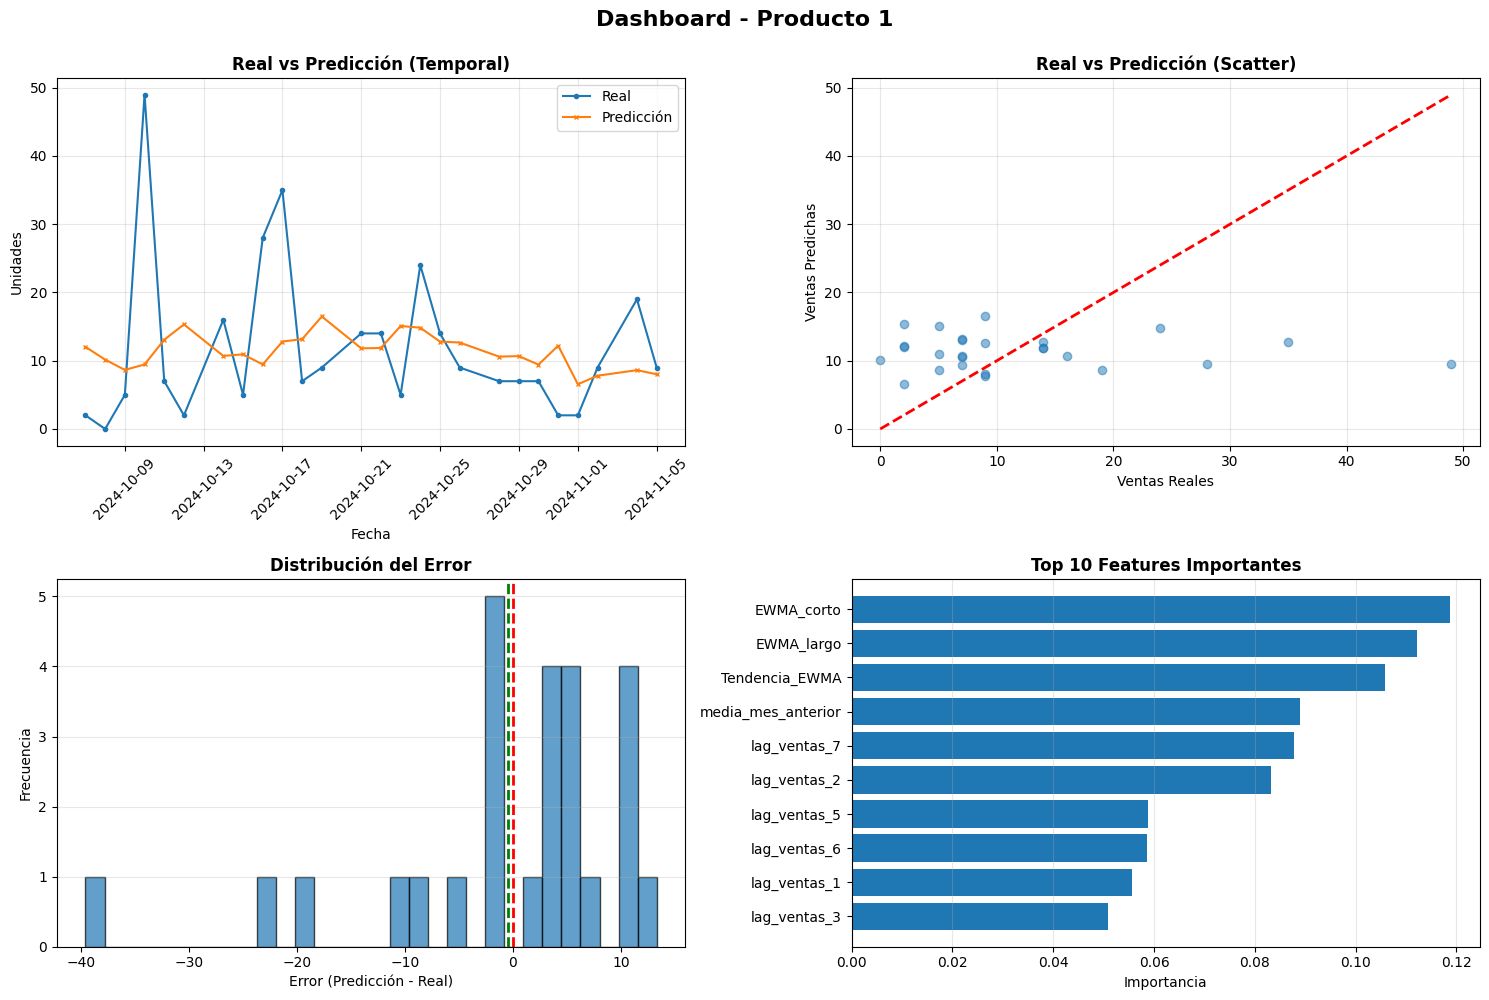


🔄 Entrenando modelo para Producto 2...
   ✓ MAE: 3.87 | RMSE: 4.73 | R²: -0.0942

   📍 Producto 2
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    6.452537 -0.547463   0.547463
    2024-10-08         7    6.007781 -0.992219   0.992219
    2024-10-09        16    6.885822 -9.114178   9.114178

   📊 Estadísticas del error:
      Error medio:              0.50
      Error abs medio:          3.87
      Error máximo:            11.20
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 2 3.8706 22.3699 4.7297 -0.0942     77.78       70.0 0.6572    61.36

🏆 Mejor modelo: RF Producto 2 (RMSE: 4.7297)


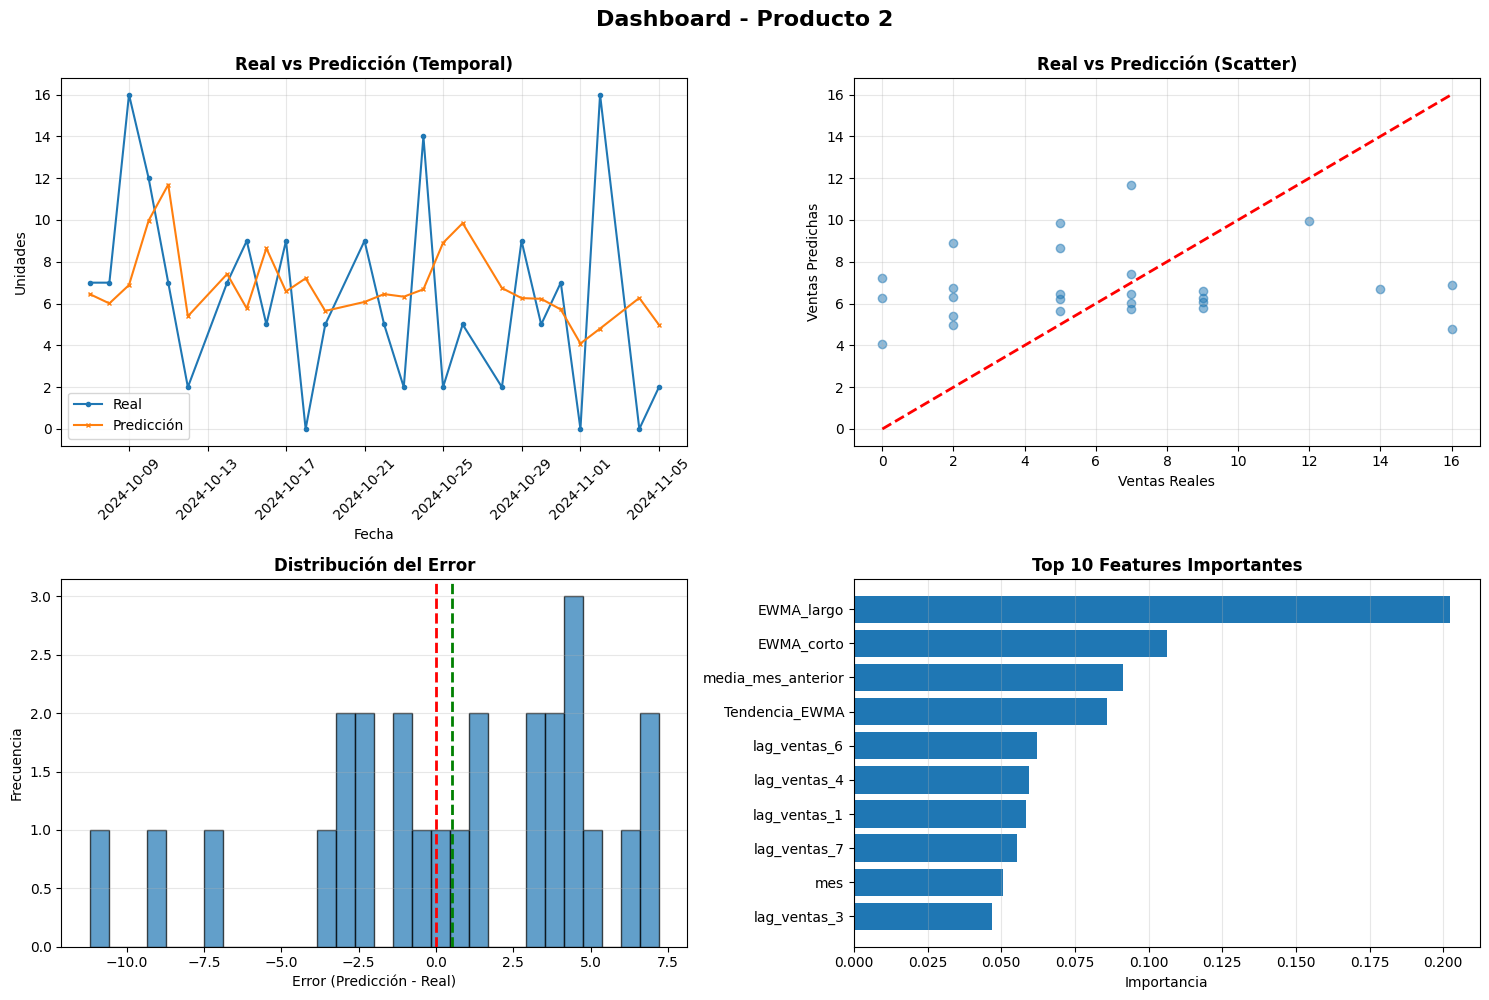


🔄 Entrenando modelo para Producto 9...
   ✓ MAE: 5.23 | RMSE: 5.80 | R²: -0.0921

   📍 Producto 9
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         9    7.890535 -1.109465   1.109465
    2024-10-08         2    9.847305  7.847305   7.847305
    2024-10-09         5    9.304937  4.304937   4.304937

   📊 Estadísticas del error:
      Error medio:              1.79
      Error abs medio:          5.23
      Error máximo:             9.04
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE  RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 9 5.2257 33.6173 5.798 -0.0921    130.43      88.25 0.7745    81.36

🏆 Mejor modelo: RF Producto 9 (RMSE: 5.7980)


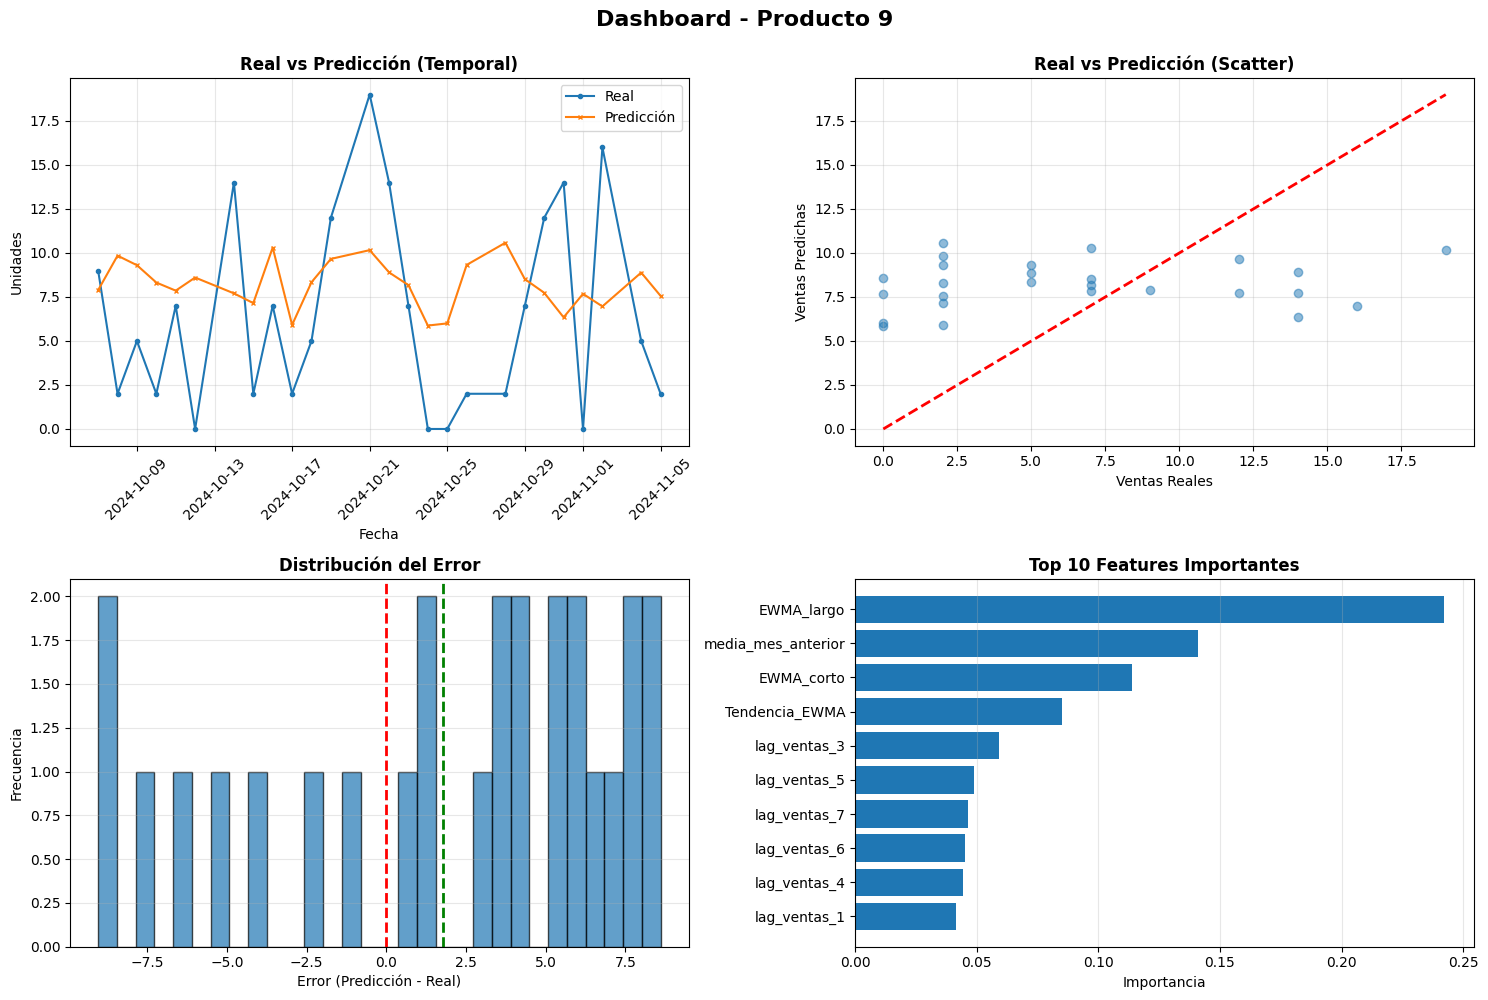


🔄 Entrenando modelo para Producto 78...
   ✓ MAE: 5.60 | RMSE: 6.86 | R²: 0.0814

   📍 Producto 78
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07        16    9.391059 -6.608941   6.608941
    2024-10-08        16    7.211078 -8.788922   8.788922
    2024-10-09        14   10.618757 -3.381243   3.381243

   📊 Estadísticas del error:
      Error medio:             -0.72
      Error abs medio:          5.60
      Error máximo:            21.08
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
      RF Producto 78 5.5967 47.1173 6.8642 0.0814     68.82      65.77 0.6829    49.49

🏆 Mejor modelo: RF Producto 78 (RMSE: 6.8642)


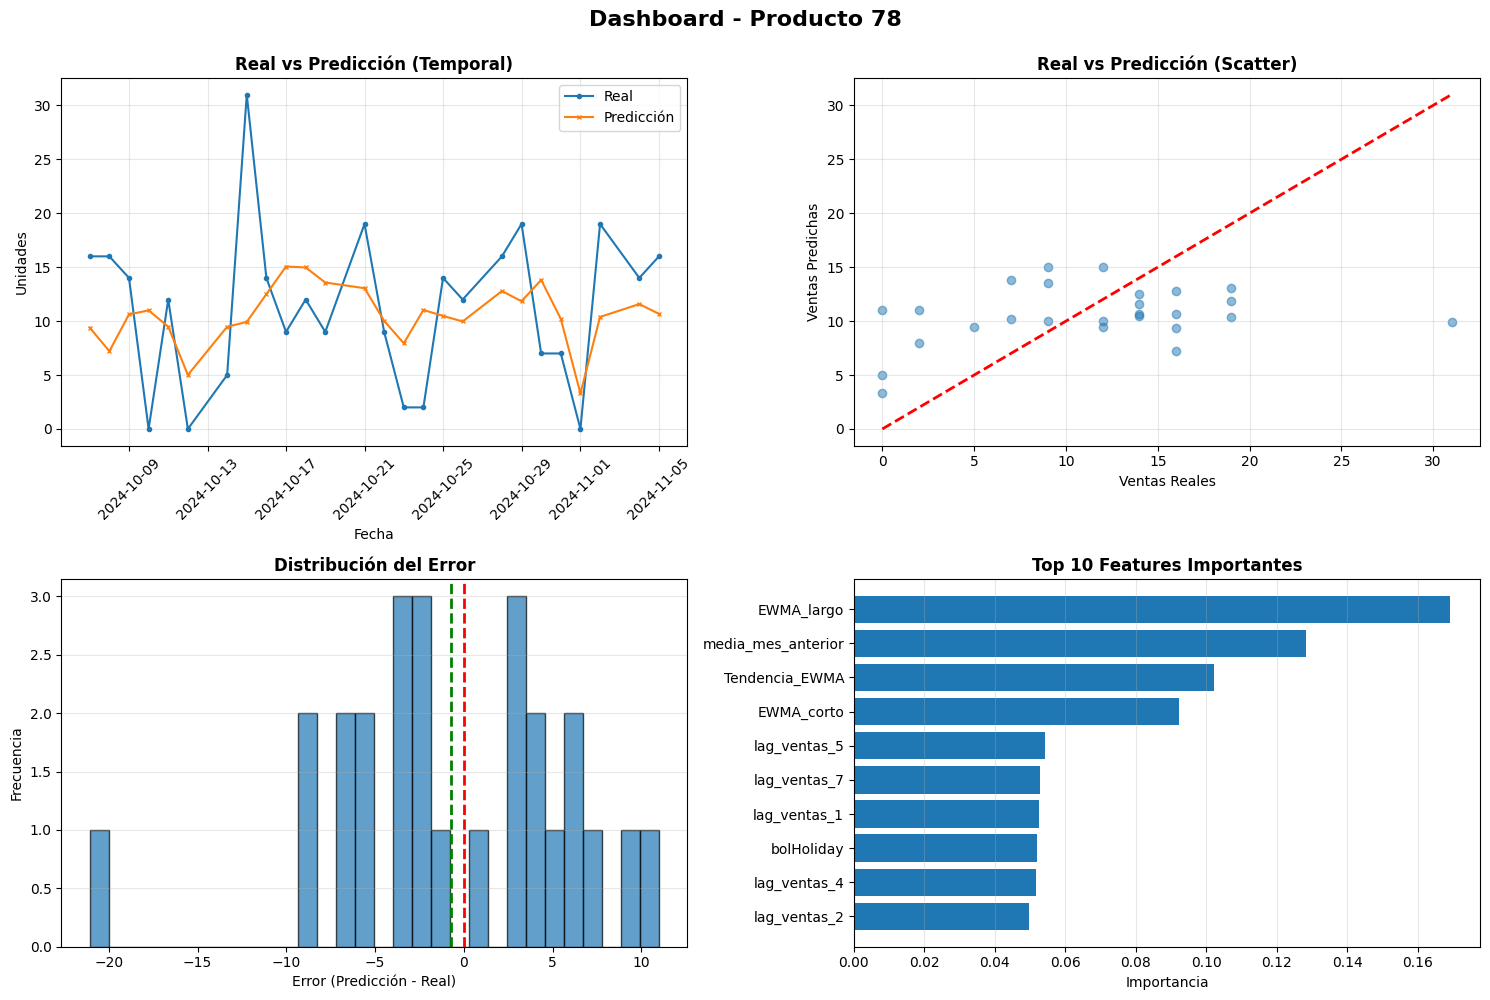


🔄 Entrenando modelo para Producto 7...
   ✓ MAE: 3.70 | RMSE: 4.03 | R²: -1.1094

   📍 Producto 7
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion    error  error_abs
    2024-10-07         0    4.873991 4.873991   4.873991
    2024-10-08         0    5.294484 5.294484   5.294484
    2024-10-09         0    6.326809 6.326809   6.326809

   📊 Estadísticas del error:
      Error medio:              2.76
      Error abs medio:          3.70
      Error máximo:             6.71
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 7 3.7039 16.2637 4.0328 -1.1094    110.61     118.04 0.9827   145.91

🏆 Mejor modelo: RF Producto 7 (RMSE: 4.0328)


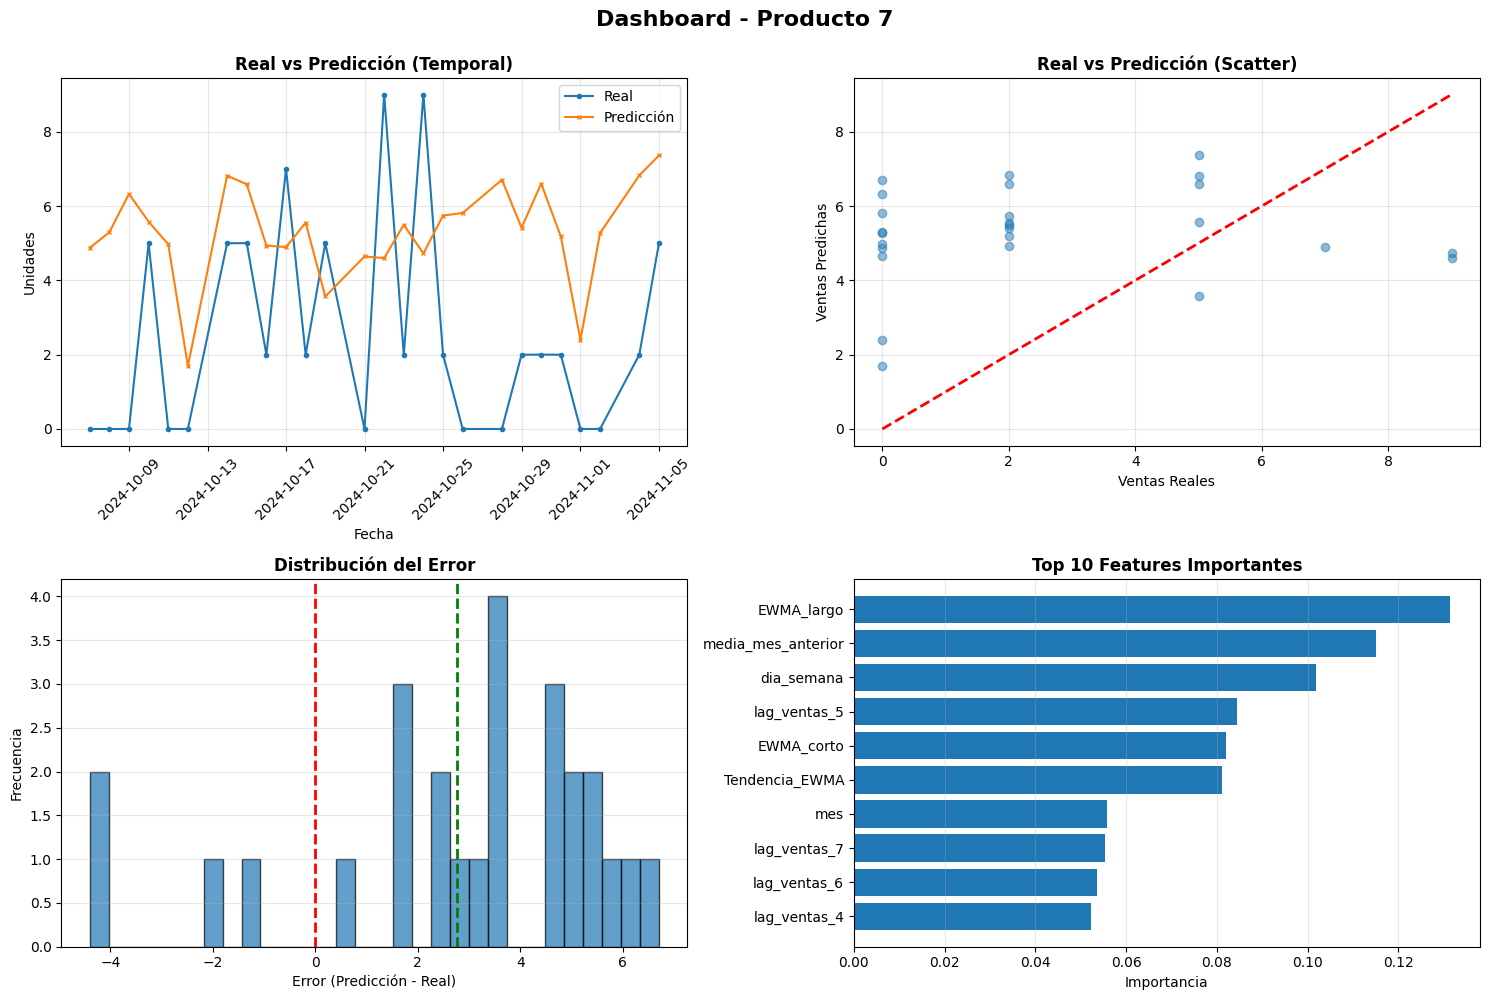


🔄 Entrenando modelo para Producto 13...
   ✓ MAE: 3.38 | RMSE: 3.93 | R²: -0.3348

   📍 Producto 13
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion    error  error_abs
    2024-10-07         2    6.800841 4.800841   4.800841
    2024-10-08         2    6.583327 4.583327   4.583327
    2024-10-09         2    6.171140 4.171140   4.171140

   📊 Estadísticas del error:
      Error medio:              1.90
      Error abs medio:          3.38
      Error máximo:             8.21
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo   MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
      RF Producto 13 3.377 15.4512 3.9308 -0.3348    108.47      84.04 0.7515    85.24

🏆 Mejor modelo: RF Producto 13 (RMSE: 3.9308)


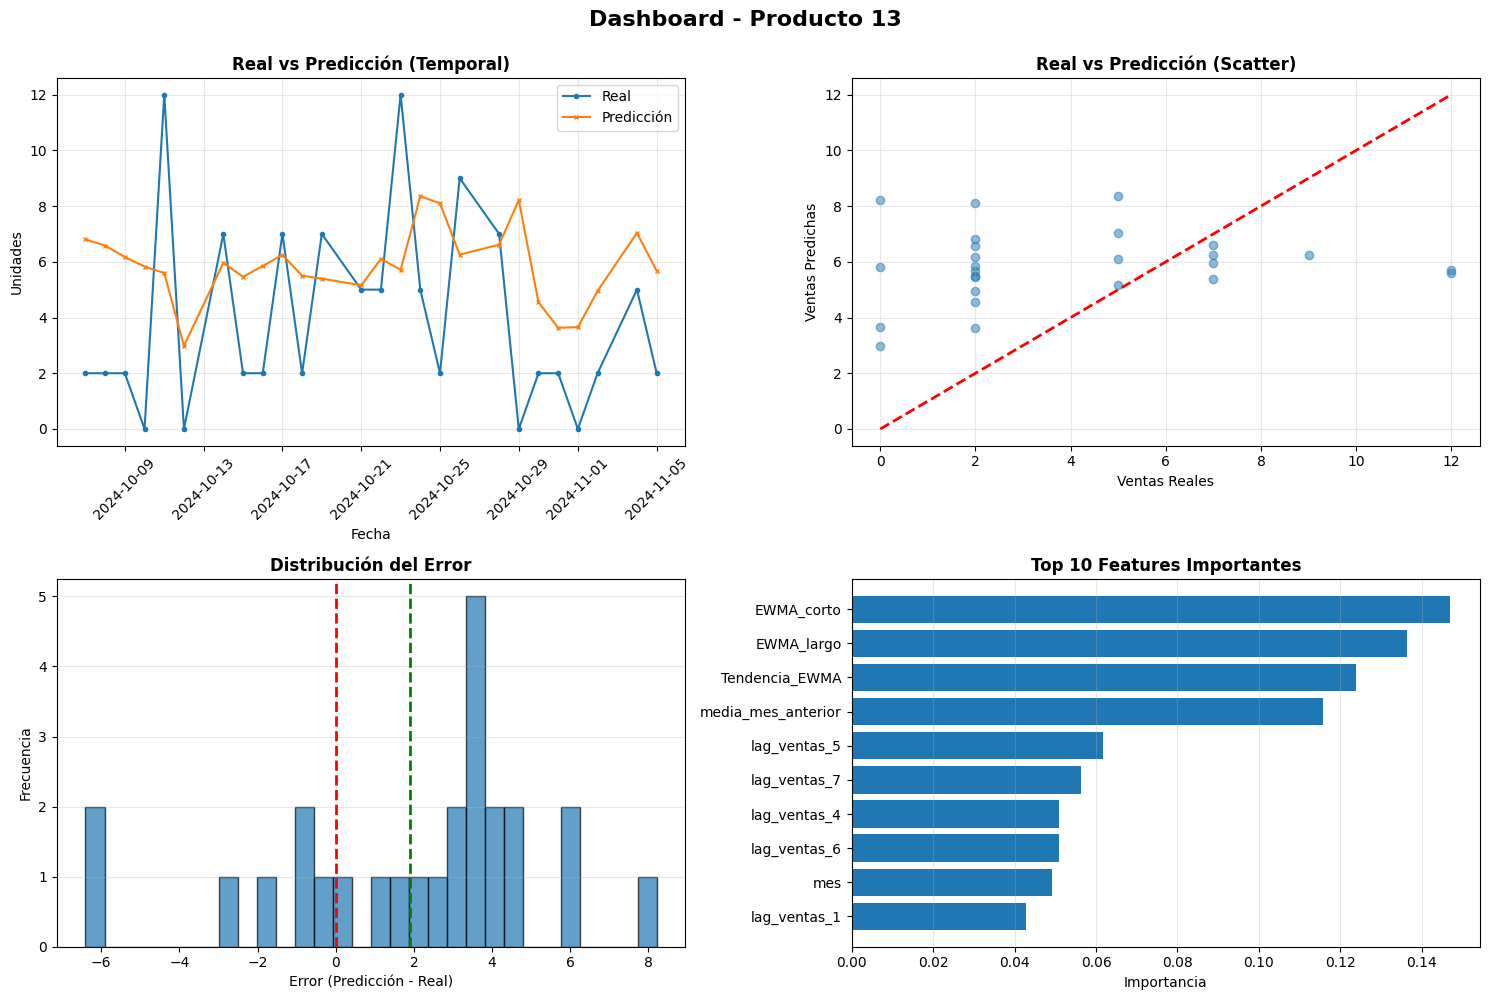


🔄 Entrenando modelo para Producto 15...
   ✓ MAE: 2.90 | RMSE: 3.81 | R²: 0.0904

   📍 Producto 15
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    6.910575 -0.089425   0.089425
    2024-10-08         5    5.428690  0.428690   0.428690
    2024-10-09         9    5.225196 -3.774804   3.774804

   📊 Estadísticas del error:
      Error medio:             -0.18
      Error abs medio:          2.90
      Error máximo:             9.19
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
      RF Producto 15 2.8961 14.5367 3.8127 0.0904      58.5      68.18 0.7305    50.88

🏆 Mejor modelo: RF Producto 15 (RMSE: 3.8127)


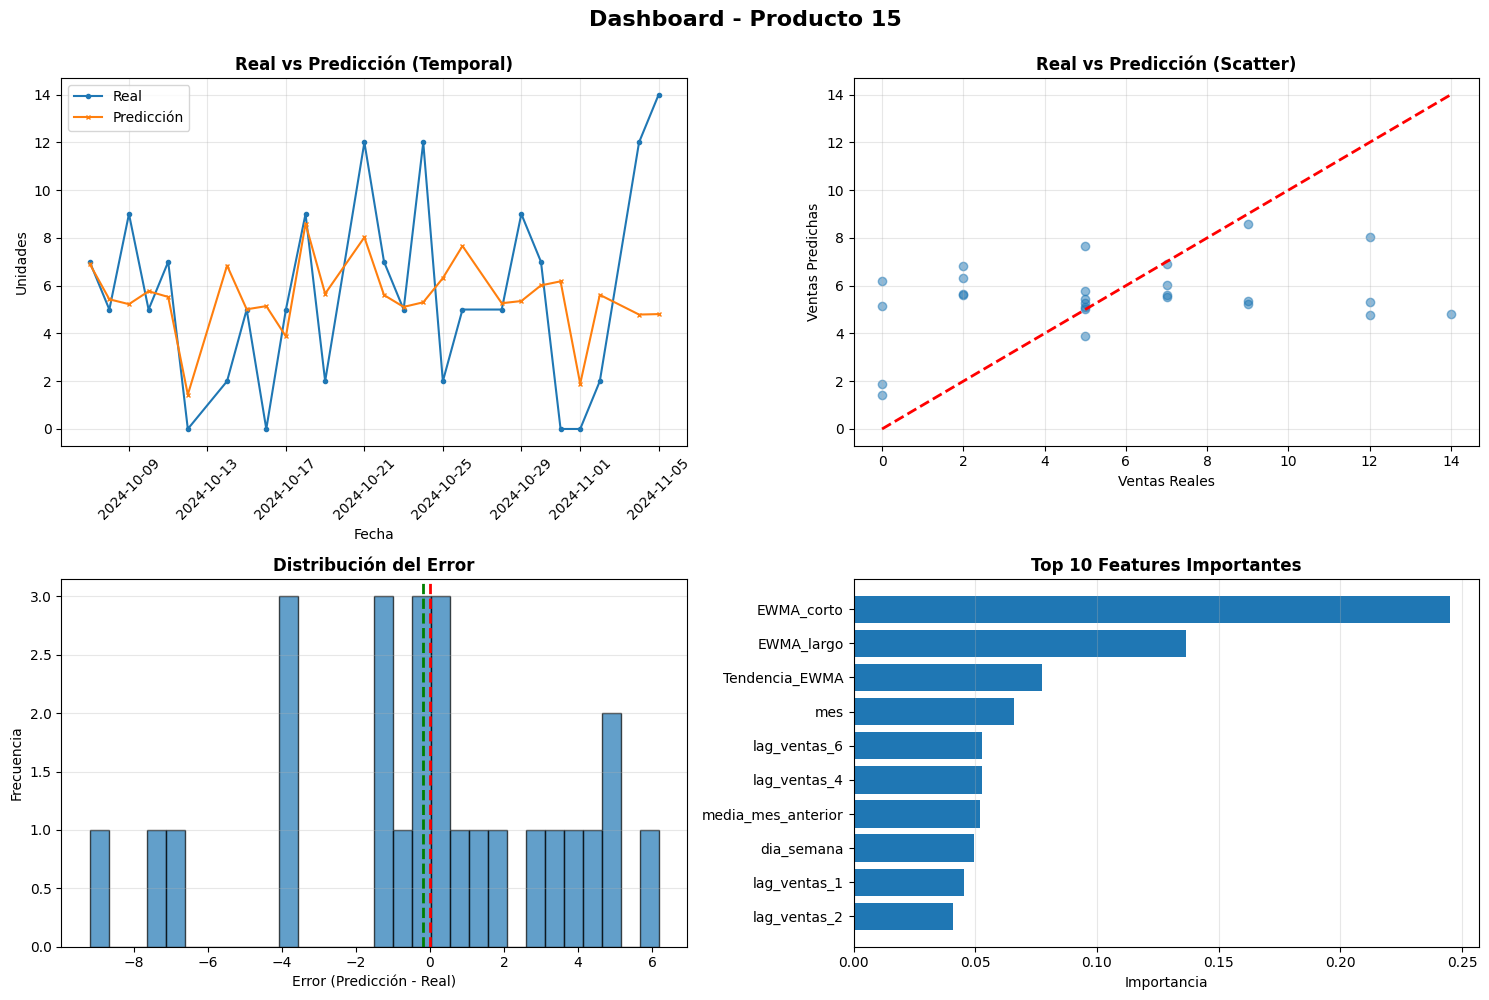


🔄 Entrenando modelo para Producto 391...
   ✓ MAE: 3.19 | RMSE: 3.88 | R²: -0.0616

   📍 Producto 391
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         5    5.042084  0.042084   0.042084
    2024-10-08         9    5.127683 -3.872317   3.872317
    2024-10-09         0    5.488466  5.488466   5.488466

   📊 Estadísticas del error:
      Error medio:              1.20
      Error abs medio:          3.19
      Error máximo:            10.30
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
     RF Producto 391 3.1874 15.0319 3.8771 -0.0616     69.71     102.52 0.6901    94.17

🏆 Mejor modelo: RF Producto 391 (RMSE: 3.8771)


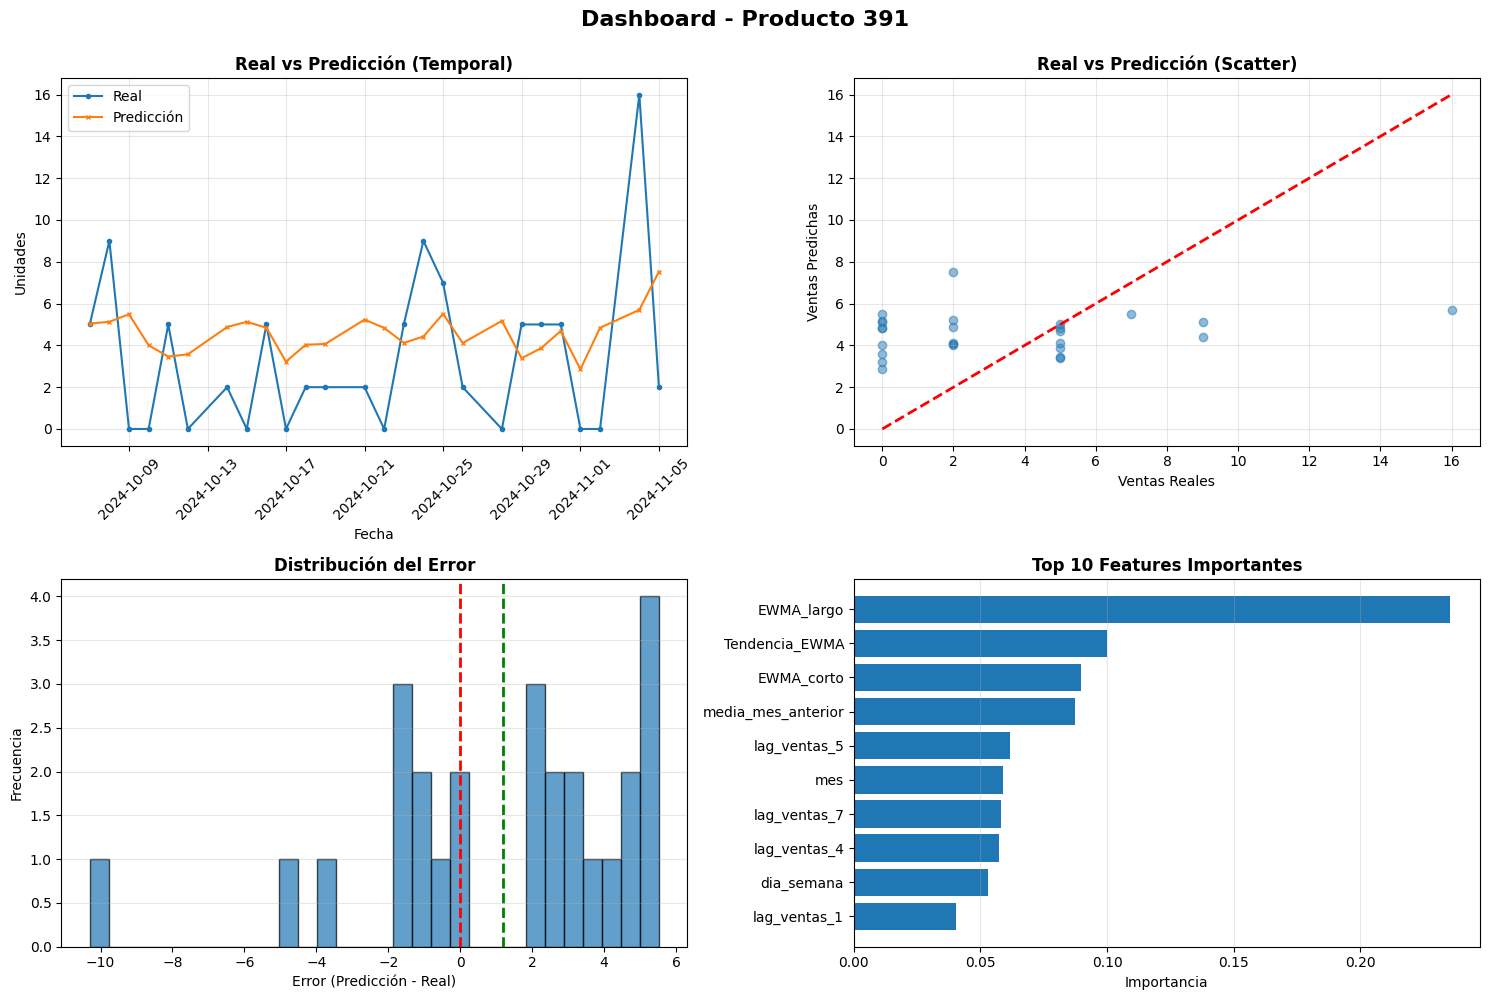


🔄 Entrenando modelo para Producto 3...
   ✓ MAE: 4.36 | RMSE: 5.54 | R²: -0.0135

   📍 Producto 3
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    5.278237 -1.721763   1.721763
    2024-10-08         5    5.341437  0.341437   0.341437
    2024-10-09         5    4.757141 -0.242859   0.242859

   📊 Estadísticas del error:
      Error medio:             -0.03
      Error abs medio:          4.36
      Error máximo:            13.31
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 3 4.3588 30.7289 5.5434 -0.0135     69.43      81.02 0.9397    67.86

🏆 Mejor modelo: RF Producto 3 (RMSE: 5.5434)


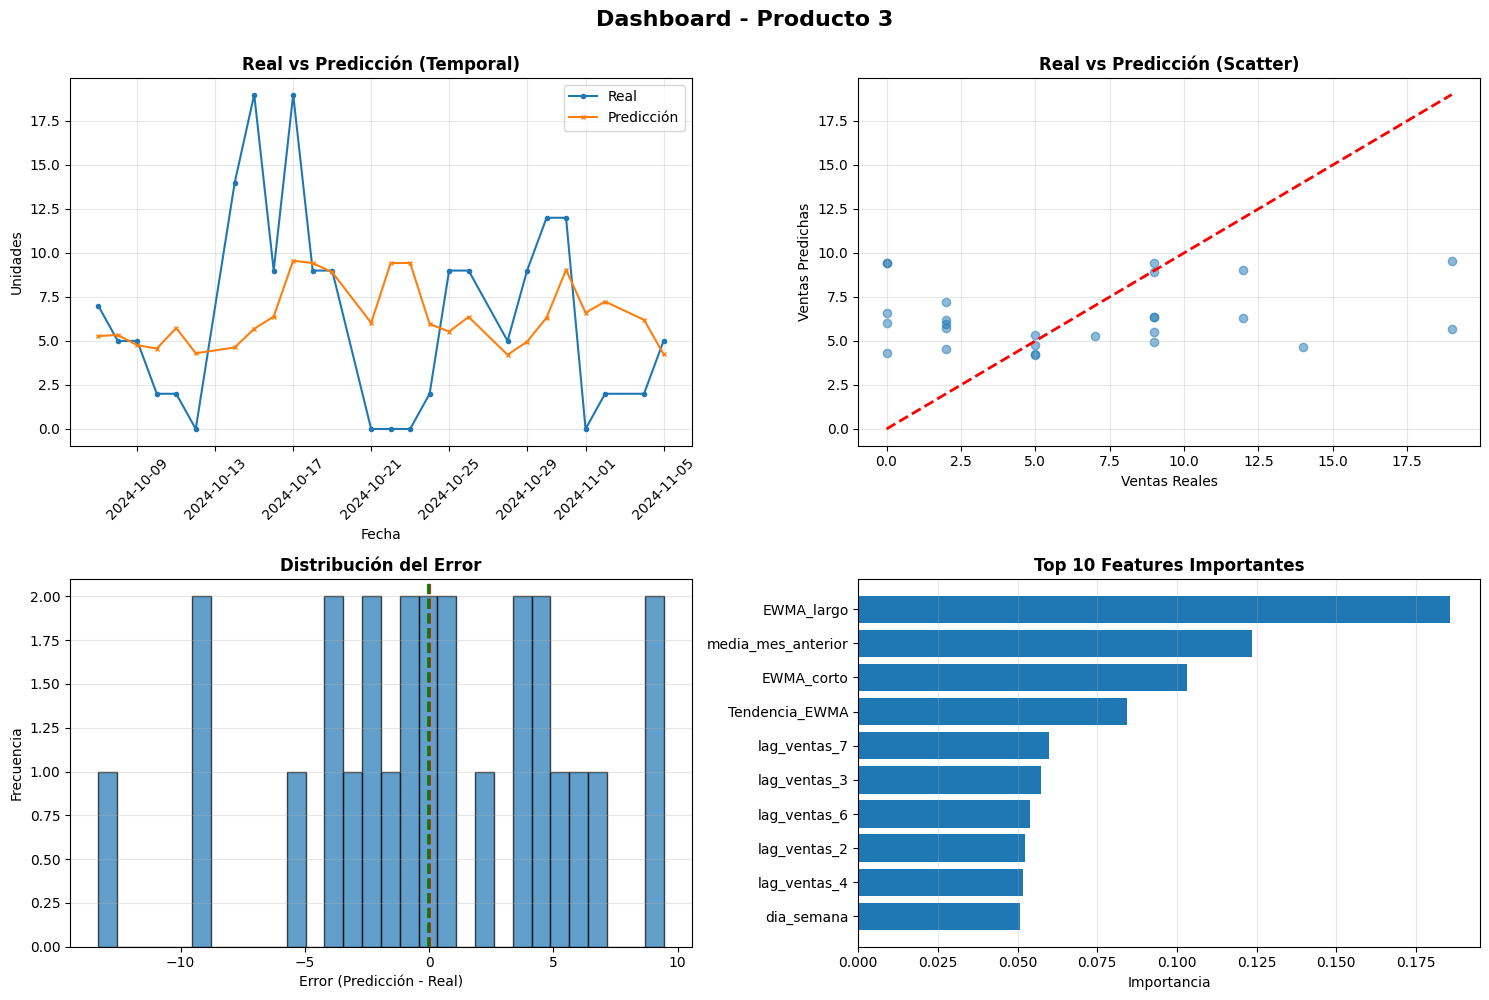


🔄 Entrenando modelo para Producto 131...
   ✓ MAE: 3.23 | RMSE: 3.79 | R²: 0.0329

   📍 Producto 131
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         9    5.231550 -3.768450   3.768450
    2024-10-08         9    6.923684 -2.076316   2.076316
    2024-10-09         2    8.384685  6.384685   6.384685

   📊 Estadísticas del error:
      Error medio:              0.80
      Error abs medio:          3.23
      Error máximo:             7.33
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
     RF Producto 131 3.2283 14.3991 3.7946 0.0329     63.52      96.53 0.7488    86.53

🏆 Mejor modelo: RF Producto 131 (RMSE: 3.7946)


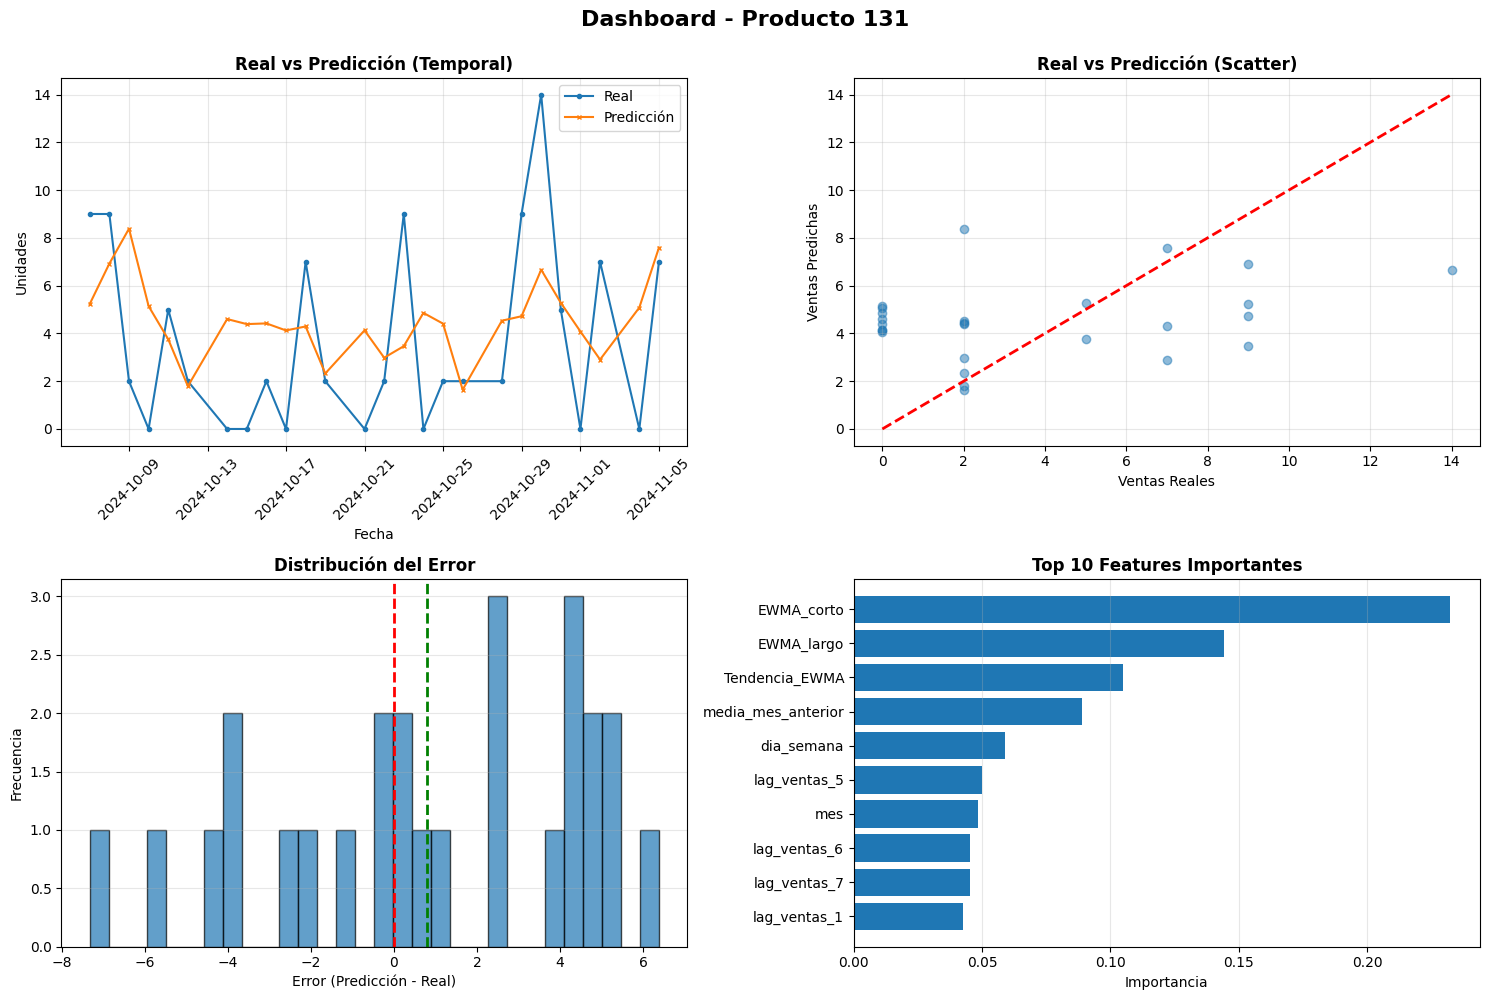

In [10]:

# ============================================================================
# 3. MODELOS POR PRODUCTO (TOP 10)
# ============================================================================

print("\n" + "="*100)
print("📍 MODELO 3: RANDOM FOREST POR PRODUCTO (TOP 10)")
print("="*100)

top_productos = df_train.groupby('producto')['udsVenta'].sum().nlargest(10).index.tolist()
print(f"\n🏆 Top 10 productos: {top_productos}")

modelos_producto = {}

for producto in top_productos:
    print(f"\n🔄 Entrenando modelo para Producto {producto}...")
    
    # Filtrar datos
    train_prod = df_train[df_train['producto'] == producto]
    test_prod = df_test[df_test['producto'] == producto].dropna()
    
    if len(test_prod) == 0:
        print(f"   ⚠️  No hay datos de validación")
        continue
    
    if len(train_prod) < 100:
        print(f"   ⚠️  Datos insuficientes ({len(train_prod)} registros)")
        continue
    
    X_train_p = train_prod[FEATURES]
    y_train_p = train_prod[TARGET]
    X_test_p = test_prod[FEATURES]
    y_test_p = test_prod[TARGET]
    
    # Entrenar
    rf_producto = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf_producto.fit(X_train_p, y_train_p)
    y_pred_p = rf_producto.predict(X_test_p)
    
    modelos_producto[producto] = rf_producto
    
    # Calcular métricas y GUARDAR
    metricas_producto = calcular_metricas(y_test_p, y_pred_p, f"RF Producto {producto}")
    todas_metricas.append(metricas_producto)
    
    print(f"   ✓ MAE: {metricas_producto['MAE']:.2f} | RMSE: {metricas_producto['RMSE']:.2f} | R²: {metricas_producto['R2']:.4f}")
    
    # Preparar datos
    test_prod_pred = test_prod.copy()
    test_prod_pred['prediccion'] = y_pred_p
    test_prod_pred['error'] = y_pred_p - test_prod_pred[TARGET]
    test_prod_pred['error_abs'] = np.abs(test_prod_pred['error'])
    test_prod_pred['error_pct'] = (test_prod_pred['error_abs'] / test_prod_pred[TARGET]) * 100
    test_prod_pred = test_prod_pred.sort_values('idSecuencia')
    
    print(f"\n   📍 Producto {producto}")
    print(f"      Train: {len(train_prod)} | Test: {len(test_prod_pred)}")
    
    # Primeras predicciones
    print(f"\n   📋 Primeras 3 predicciones:")
    cols = ['idSecuencia', TARGET, 'prediccion', 'error', 'error_abs']
    print("   " + test_prod_pred[cols].head(3).to_string(index=False).replace('\n', '\n   '))
    
    # Estadísticas
    print(f"\n   📊 Estadísticas del error:")
    print(f"      Error medio:          {test_prod_pred['error'].mean():>8.2f}")
    print(f"      Error abs medio:      {test_prod_pred['error_abs'].mean():>8.2f}")
    print(f"      Error máximo:         {test_prod_pred['error_abs'].max():>8.2f}")
    print(f"      Error % medio:        {test_prod_pred['error_pct'].mean():>8.2f}%")
    
    if len(test_prod_pred) >= 2:
        resumen_metricas([metricas_producto])
        
        try:
            dashboard_prediccion(
                df=test_prod_pred,
                col_fecha='idSecuencia',
                col_real=TARGET,
                col_pred='prediccion',
                modelo=rf_producto,
                feature_names=FEATURES,
                titulo_principal=f'Dashboard - Producto {producto}',
                figsize=(15, 10)
            )
        except Exception as e:
            print(f"   ⚠️  Error en dashboard: {str(e)}")


# Resumen final


🏆 RESUMEN FINAL - COMPARACIÓN DE TODOS LOS MODELOS

📊 Resumen de todas las métricas:

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE      MSE    RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
        RF Cluster 3 1.0892   2.7937  1.6714  0.0639     53.99     168.34 0.7500   134.12
      RF Global Test 1.5756   5.7646  2.4010  0.2477     49.34     144.46 0.7358    96.49
        RF Cluster 0 1.8095   6.7016  2.5887  0.0896     40.22     125.96 0.7442    93.71
        RF Cluster 1 2.7822  12.9301  3.5958  0.1400     55.63      99.34 0.7187    72.96
     RF Producto 131 3.2283  14.3991  3.7946  0.0329     63.52      96.53 0.7488    86.53
      RF Producto 15 2.8961  14.5367  3.8127  0.0904     58.50      68.18 0.7305    50.88
     RF Producto 391 3.1874  15.0319  3.8771 -0.0616     69.71     102.52 0.6901    94.17
      RF Producto 13 3.3770  15.4512  3.9308 -0.3348    108.47      84.04 0.7515    85.24
       RF Producto 7 3.7039  16.2637  4.0328 -1.1094    110.61     118.04 0.9827 

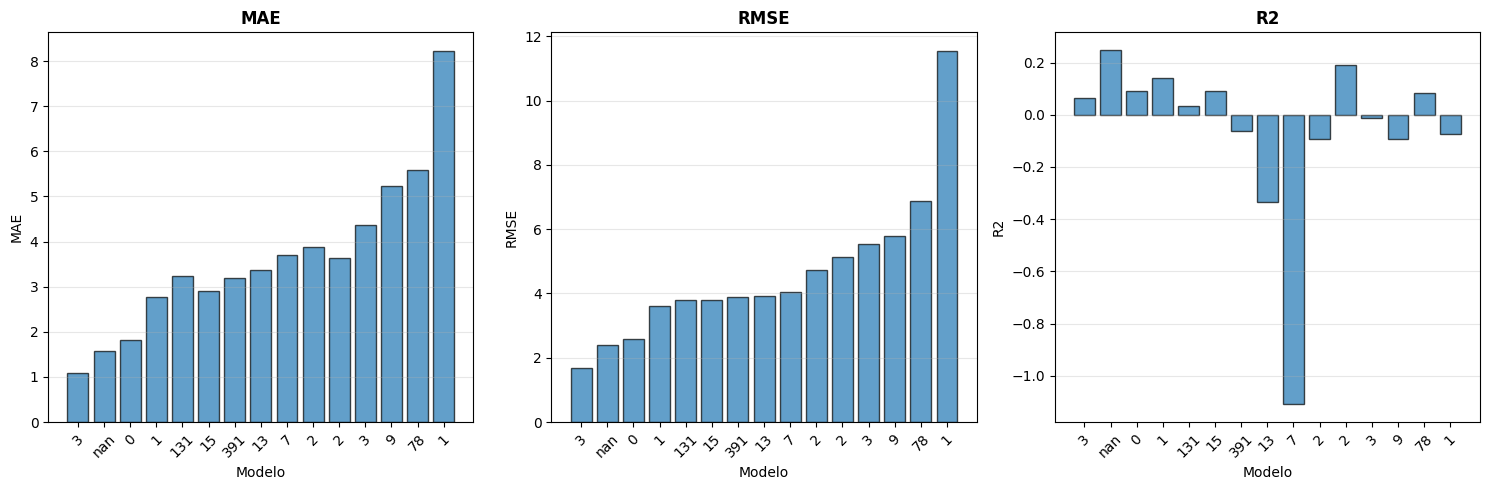


📊 ANÁLISIS POR CATEGORÍAS DE MODELOS

🌍 MODELOS GLOBALES:
     Algoritmo    MAE  RMSE     R2
RF Global Test 1.5756 2.401 0.2477

   Promedio RMSE: 2.40

🎯 MODELOS POR CLUSTER:
   Algoritmo    MAE   RMSE     R2
RF Cluster 3 1.0892 1.6714 0.0639
RF Cluster 0 1.8095 2.5887 0.0896
RF Cluster 1 2.7822 3.5958 0.1400
RF Cluster 2 3.6334 5.1213 0.1895

   Promedio RMSE: 3.24
   Mejor cluster: RF Cluster 3 (RMSE: 1.67)
   Peor cluster: RF Cluster 2 (RMSE: 5.12)

🛒 MODELOS POR PRODUCTO:
      Algoritmo    MAE    RMSE      R2
RF Producto 131 3.2283  3.7946  0.0329
 RF Producto 15 2.8961  3.8127  0.0904
RF Producto 391 3.1874  3.8771 -0.0616
 RF Producto 13 3.3770  3.9308 -0.3348
  RF Producto 7 3.7039  4.0328 -1.1094
  RF Producto 2 3.8706  4.7297 -0.0942
  RF Producto 3 4.3588  5.5434 -0.0135
  RF Producto 9 5.2257  5.7980 -0.0921
 RF Producto 78 5.5967  6.8642  0.0814
  RF Producto 1 8.2253 11.5470 -0.0746

   Promedio RMSE: 5.39
   Mejor producto: RF Producto 131 (RMSE: 3.79)
   Peor producto

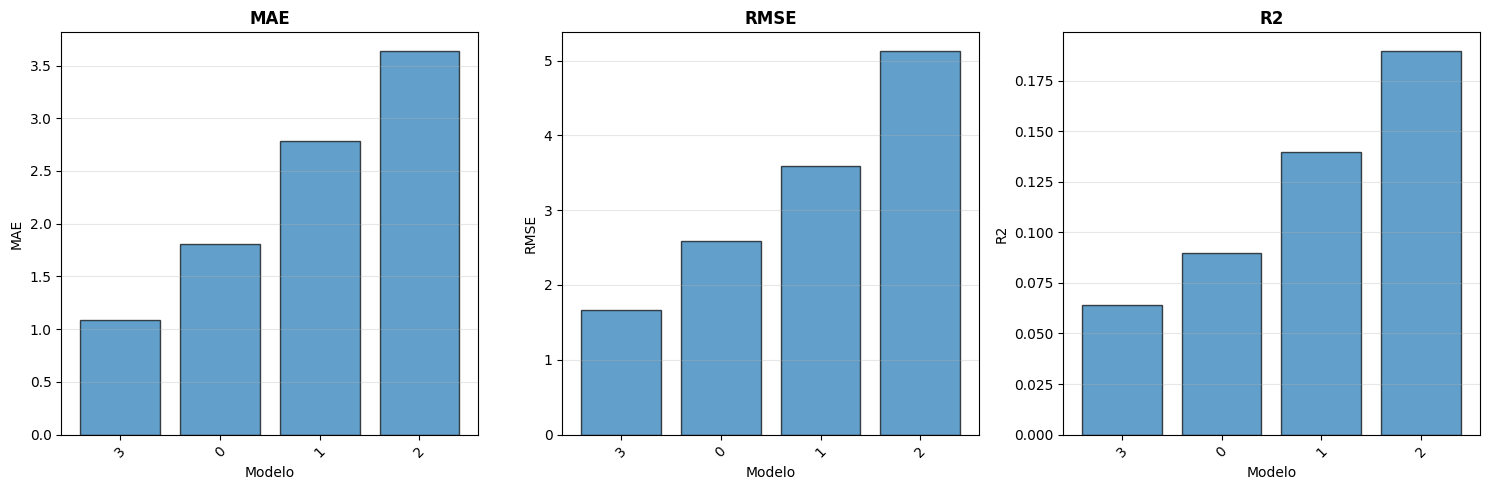


📊 Comparación entre productos:


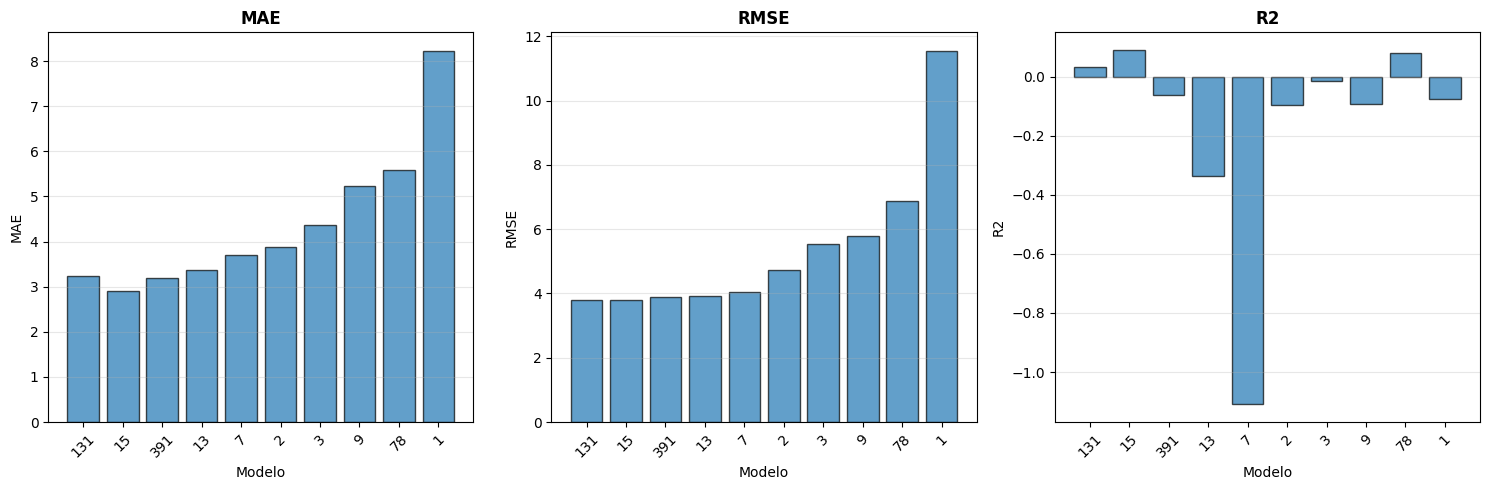


✅ ANÁLISIS COMPLETO FINALIZADO

📊 Total de modelos evaluados: 15
   - Modelos globales: 1
   - Modelos por cluster: 4
   - Modelos por producto: 10


In [11]:

# ============================================================================
# 4. RESUMEN FINAL DE TODOS LOS MODELOS
# ============================================================================

print("\n" + "="*100)
print("🏆 RESUMEN FINAL - COMPARACIÓN DE TODOS LOS MODELOS")
print("="*100)

if todas_metricas:
    # Mostrar tabla completa de métricas
    print("\n📊 Resumen de todas las métricas:")
    resumen_metricas(todas_metricas)
    
    # Comparar métricas
    df_comparacion_final = comparar_metricas(todas_metricas, ordenar_por='RMSE')
    
    print("\n" + "="*100)
    print("📈 RANKING DE MODELOS POR RMSE")
    print("="*100)
    print(df_comparacion_final[['Algoritmo', 'MAE', 'RMSE', 'R2', 'MAPE (%)']].to_string(index=False))
    
    # Gráfico comparativo de TODOS los modelos
    print("\n📊 Generando gráficos comparativos...")
    grafico_comparacion_metricas(df_comparacion_final, metricas=['MAE', 'RMSE', 'R2'])
    
    # Análisis por categorías
    print("\n" + "="*100)
    print("📊 ANÁLISIS POR CATEGORÍAS DE MODELOS")
    print("="*100)
    
    # Separar por tipo de modelo
    df_global = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Global')]
    df_clusters = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Cluster')]
    df_productos = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Producto')]
    
    print("\n🌍 MODELOS GLOBALES:")
    if len(df_global) > 0:
        print(df_global[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_global['RMSE'].mean():.2f}")
    
    print("\n🎯 MODELOS POR CLUSTER:")
    if len(df_clusters) > 0:
        print(df_clusters[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_clusters['RMSE'].mean():.2f}")
        print(f"   Mejor cluster: {df_clusters.iloc[0]['Algoritmo']} (RMSE: {df_clusters.iloc[0]['RMSE']:.2f})")
        print(f"   Peor cluster: {df_clusters.iloc[-1]['Algoritmo']} (RMSE: {df_clusters.iloc[-1]['RMSE']:.2f})")
    
    print("\n🛒 MODELOS POR PRODUCTO:")
    if len(df_productos) > 0:
        print(df_productos[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_productos['RMSE'].mean():.2f}")
        print(f"   Mejor producto: {df_productos.iloc[0]['Algoritmo']} (RMSE: {df_productos.iloc[0]['RMSE']:.2f})")
        print(f"   Peor producto: {df_productos.iloc[-1]['Algoritmo']} (RMSE: {df_productos.iloc[-1]['RMSE']:.2f})")
    
    # Mejor modelo general
    print("\n" + "="*100)
    print("🥇 MEJOR MODELO GENERAL")
    print("="*100)
    mejor_idx = df_comparacion_final['RMSE'].idxmin()
    mejor_modelo = df_comparacion_final.loc[mejor_idx]
    
    print(f"\n🏆 {mejor_modelo['Algoritmo']}")
    print(f"   MAE:        {mejor_modelo['MAE']:.2f}")
    print(f"   RMSE:       {mejor_modelo['RMSE']:.2f}")
    print(f"   R²:         {mejor_modelo['R2']:.4f}")
    print(f"   MAPE:       {mejor_modelo['MAPE (%)']:.2f}%")
    print(f"   SMAPE:      {mejor_modelo['SMAPE (%)']:.2f}%")
    
    # Gráficos comparativos por categoría
    if len(df_clusters) > 1:
        print("\n📊 Comparación entre clusters:")
        grafico_comparacion_metricas(df_clusters, metricas=['MAE', 'RMSE', 'R2'])
    
    if len(df_productos) > 1:
        print("\n📊 Comparación entre productos:")
        grafico_comparacion_metricas(df_productos, metricas=['MAE', 'RMSE', 'R2'])
    
else:
    print("\n⚠️  No se generaron métricas para ningún modelo")

print("\n" + "="*100)
print("✅ ANÁLISIS COMPLETO FINALIZADO")
print("="*100)
print(f"\n📊 Total de modelos evaluados: {len(todas_metricas)}")
print(f"   - Modelos globales: {len([m for m in todas_metricas if 'Global' in m['Algoritmo']])}")
print(f"   - Modelos por cluster: {len([m for m in todas_metricas if 'Cluster' in m['Algoritmo']])}")
print(f"   - Modelos por producto: {len([m for m in todas_metricas if 'Producto' in m['Algoritmo']])}")